In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans

env_path = "/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/"
sys.path.append(env_path)

import scanpy as sc

In [2]:
bj = pd.read_csv("../resources/Fibroblast_BJ_20210505_AC.csv")
print(f"{bj.shape=}")
bj.columns = ['gene_name', 'tpm']
bj = bj.sort_values(by='tpm', ascending=False)

# exlude certain classes of genes
bj = bj[~bj['gene_name'].str.startswith("RP")]
bj = bj[~bj['gene_name'].str.startswith("MT")]

bj.head()

bj.shape=(19379, 2)


,gene_name,tpm
17188,TMSB10,45584.16
14333,S100A6,35129.31
8725,LGALS1,22412.13
17191,TMSB4X,15365.34
10196,MYL6,14625.02


# Identify the cells that Walter Spiked in

- CD34-
- TF-
- V5-

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/clustered.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 8562 × 14972
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [4]:
df = adata.to_df()
df.columns = adata.var['gene_name'].values

genes = [
    'CD34', 
    'GATA2', 
    'GFI1B',
    'REL',
    'STAT5A',
    'FOS',
]

for g in genes:
    adata.obs[g] = np.where(df[g] > 0, True, False)
adata.obs['sum_gene'] = adata.obs[genes].sum(axis=1)

adata.obs['sum_gene'].value_counts(normalize=True)

sum_gene
0    0.471268
1    0.364634
2    0.130577
3    0.029900
4    0.003621
Name: proportion, dtype: float64

In [5]:
tag_columns = ['V5-FOS', 'V5-GATA2','V5-REL', 'V5-STAT5A']
v5_counts = adata.uns['v5_tags'][tag_columns].sum(axis=1)
v5_counts = v5_counts[v5_counts.values < 1]
idx = v5_counts.index

adata.obs['v5_pos'] = np.where(adata.obs.index.isin(idx), 1, 0)
adata.obs['all_flags'] = adata.obs['v5_pos'] + adata.obs['sum_gene']

adata.obs['all_flags'].value_counts(normalize=True)

all_flags
0    0.469867
1    0.365335
2    0.130694
3    0.030250
4    0.003854
Name: proportion, dtype: float64

In [6]:
pdf = adata.copy()

pdf.var_names = pdf.var['gene_name'].values

sc.pp.filter_genes(pdf, min_counts=100)
sc.pp.filter_cells(pdf, min_counts=500)

sc.pp.highly_variable_genes(pdf)

sc.tl.pca(pdf)
sc.pp.neighbors(pdf)
sc.tl.umap(pdf)

pdf

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 8544 × 11276
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CD34', 'GATA2', 'GFI1B', 'REL', 'STAT5A', 'FOS', 'sum_gene', 'v5_pos', 'all_flags', 'n_counts'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'n_counts'
    uns: 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

/tmp/ipykernel_1392019/2334057725.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(pdf,


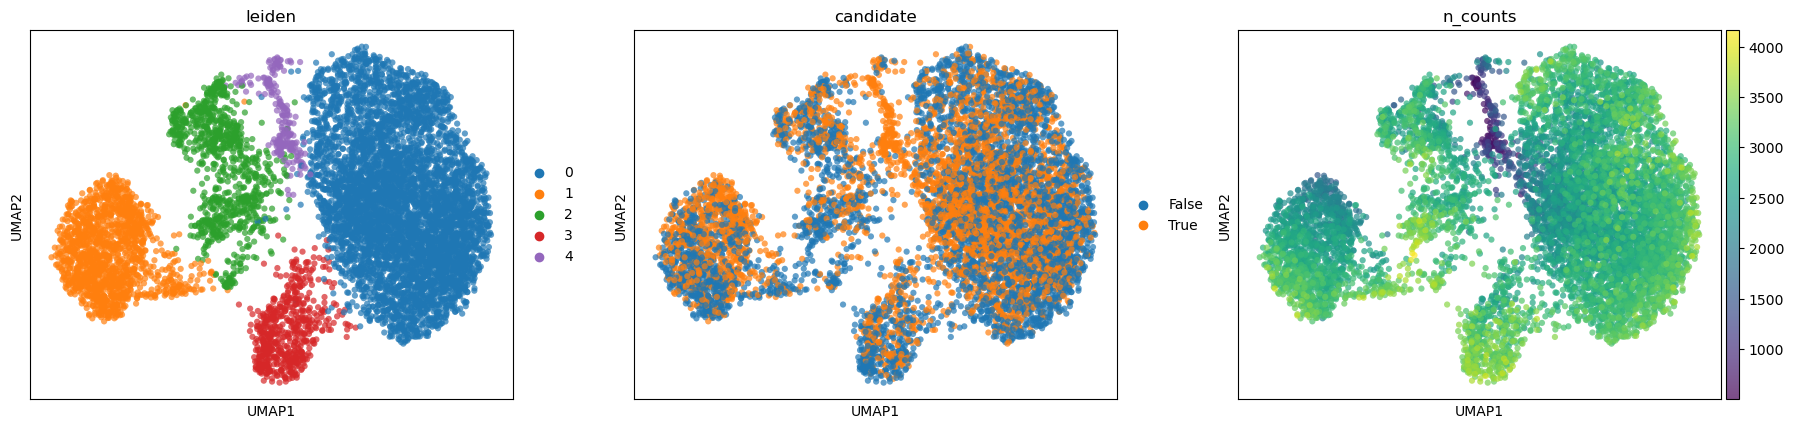

In [7]:
sc.tl.leiden(pdf,
             resolution=0.2, 
             n_iterations=2,
            )

pdf.obs['candidate'] = np.where(pdf.obs['all_flags'] > 0, False, True)

sc.pl.umap(pdf, 
           s=80,
           alpha=0.7,
           color=["leiden", "candidate", "n_counts"])

# Generate focused gene lists

In [8]:
""" BJ specific reference set """
bj_genes = bj[bj['tpm'] > bj['tpm'].quantile(.99)]
bj_genes = bj_genes['gene_name'].values

""" general HSC markers  """
panglao = pdf.uns['panglaodb']
hsc_name = "Hematopoietic stem cells"
hsc_genes = panglao[panglao['cell_type'] == hsc_name].sort_values(by='ubiquitousness_index')
hsc_genes = hsc_genes['gene_name'].values


""" tabula sapiens markers """
tdf = pdf.uns['tabula_sapiens_deg']

tdf = tdf[tdf['pct_nz_group'] > 0.85]
tdf = tdf[tdf['logfoldchanges'] > 1.0]

# drop nans
tdf = tdf.replace([np.inf, -np.inf], np.nan)
tdf = tdf.dropna()

# drop certain classes of genes
tdf = tdf[~tdf['gene_name'].str.startswith("RP")]
tdf = tdf[~tdf['gene_name'].str.startswith("MT")]

tdf = tdf.sort_values(by=['cell_type', 'logfoldchanges'], ascending=False)

tdf = tdf.groupby('cell_type')['gene_name'].agg(list)
tdf.index = tdf.index.map(lambda x: f"ts_{x.replace(' ', '_')}")


marker_genes = {
    'bj_fibroblast' : bj_genes,
    'pangloa_hsc' : hsc_genes,
} | tdf.to_dict()

for k,v in marker_genes.items():
    print(f"{k} n genes {len(v)=}")

bj_fibroblast n genes len(v)=192
pangloa_hsc n genes len(v)=73
ts_fibroblast n genes len(v)=67
ts_hematopoietic_stem_cell n genes len(v)=108


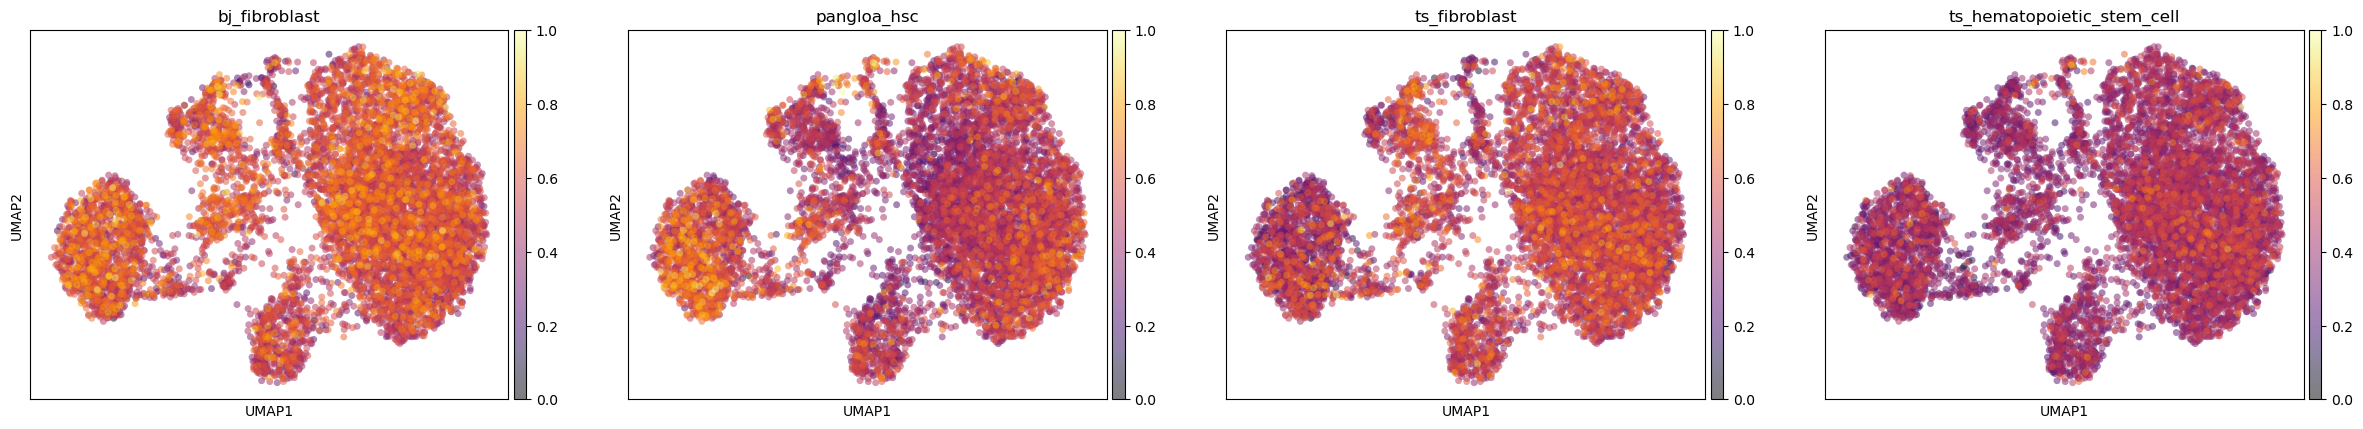

In [9]:
# score the gene sets
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

def filter_genes(gene_list, pdf):
    return [x for x in gene_list if x in pdf.var['gene_name'].values]

for k, v in marker_genes.items():
    
    gene_names = filter_genes(v, pdf)
    
    sc.tl.score_genes(pdf,
                      gene_list=gene_names, 
                      ctrl_size=len(gene_names),
                      n_bins=10,
                      score_name=k)
    
    # normalize the scores
    pdf.obs[k] = min_max(pdf.obs[k])
    

sc.pl.umap(pdf, 
       s=100,
       cmap='inferno',
       alpha=0.5,
       color=list(marker_genes.keys()))

In [11]:
def filter_cells(df, low_columns=['ts_hematopoietic_stem_cell', 'pangloa_hsc'], low_percentile=0.5):
    """
    Filters a dataframe based on high/low expression criteria and candidate status.

    Args:
        df (pd.DataFrame): The dataframe to filter.
        low_columns (list): Columns for which low values are desired.
        low_percentile (float): Percentile to define 'low' threshold (default: 0.25).

    Returns:
        pd.DataFrame: The filtered dataframe.
    """

    # Calculate thresholds based on specified percentiles
    low_thresholds = df[low_columns].quantile(low_percentile)

    # Filter based on thresholds and candidate column
    filtered_df = df[
        (df[low_columns] <= low_thresholds).all(axis=1) &
        (df['candidate'] == True)
    ]

    return filtered_df

res = filter_cells(pdf.obs)
print(f"{res.shape=}")
res.head()

res.shape=(1182, 23)


,n_genes,doublet_score,predicted_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CD34,GATA2,GFI1B,...,sum_gene,v5_pos,all_flags,n_counts,leiden,candidate,bj_fibroblast,pangloa_hsc,ts_fibroblast,ts_hematopoietic_stem_cell
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAGTACCTAAC,2620,0.169399,False,2620,9006,0,0.0,False,False,False,...,0,0,0,2880.500244,0,True,0.359530,0.377156,0.269595,0.199263
AAACGAACAGCGAACA,1918,0.027108,False,1918,4876,0,0.0,False,False,False,...,0,0,0,2786.532471,1,True,0.592711,0.388164,0.304070,0.227073
AAAGGATAGCCACAAG,518,0.032046,False,518,1190,0,0.0,False,False,False,...,0,0,0,1348.150024,2,True,0.552283,0.356703,0.465378,0.364660
AAAGGATGTCTCAAGT,1759,0.041409,False,1759,5679,0,0.0,False,False,False,...,0,0,0,2452.005371,0,True,0.498311,0.373920,0.425816,0.325114
AAAGGGCAGCGCGTTC,828,0.045226,False,828,1548,0,0.0,False,False,False,...,0,0,0,1865.812256,1,True,0.410119,0.179601,0.441950,0.297738


In [17]:
candidates = pd.DataFrame({'barcode' : res.reset_index()['cell_id'].values})
outpath = "../resources/spiked_in_candidates.csv"

candidates.to_csv(outpath, index=False)
candidates.shape

(1182, 1)

In [18]:
1182 / 8562

0.13805185704274703

In [ ]:
break

In [ ]:
pdf.obs.columns

In [ ]:
break

In [ ]:
n_clusters = 4

features = [
    'candidate',
    'bj_score_pos', 
    # 'bj_score_neg',
    'n_genes_by_counts',
    'total_counts',
    'n_genes',
]

kmeans = KMeans(n_clusters=n_clusters)
features = np.hstack([pdf.obsm['X_pca'][:, 0:20], pdf.obs[features].astype(float)])
kmeans.fit(features)

pdf.obs['cluster'] = kmeans.labels_
pdf.obs['cluster'] = pdf.obs['cluster'].astype('category')

sc.pl.umap(pdf, 
           s=30,
           color=['cluster', 'CD34'])


In [ ]:
gx = pdf.obs.groupby('cluster').agg(
    num_cells = ('candidate', 'count'),
    num_candidates = ('candidate', 'sum'),
    bj_positive_mean = ('bj_score_pos', 'mean'),
    # bj_negative_mean = ('bj_score_neg', 'mean'),
).reset_index()

gx = pd.melt(gx, id_vars='cluster')


sns.catplot(data=gx, 
            x="cluster", 
            y="value",
            col="variable",
            hue='cluster',
            ec='k',
            sharey=False,
            col_wrap=3,
            kind="bar")

In [ ]:
pdf.obsm['X_pca'].shape

In [ ]:
break

# extract cluster 0

In [ ]:
idx = pdf.obs[(pdf.obs['leiden'] == '0') & pdf.obs['candidate']].index
cdf = pdf[idx, :]

sc.tl.pca(cdf, use_highly_variable=False)
sc.pp.neighbors(cdf, n_neighbors=11)
sc.tl.umap(cdf, min_dist=0.05)

sc.tl.leiden(cdf,
             resolution=0.4, 
             n_iterations=2,
            )

cdf

In [ ]:
sc.pl.umap(cdf, 
           s=150,
           alpha=0.7,
           palette='Accent',
           add_outline=True,
           color=["leiden",])

# BJ Signature

In [ ]:
df = pd.read_csv("../resources/Fibroblast_BJ_20210505_AC.csv")
print(df.shape)
df.head()

In [ ]:
tmp_threshold = 5

gene_names = df[df['TPM'] > tmp_threshold]
gene_ids  = cdf.var[cdf.var['gene_name'].isin(gene_names['Gene'].values)].index

sc.tl.score_genes(cdf,
                  gene_list=gene_ids, 
                  n_bins=10,
                  score_name='bj_score')

sc.pl.umap(cdf, 
           s=150,
           alpha=0.7,
           color="bj_score",)

In [ ]:
sc.pl.umap(cdf, 
           s=150,
           alpha=0.7,
           palette='Accent',
           add_outline=True,
           color=["leiden",])

In [ ]:
break

In [ ]:
genes = adata.uns['panglaodb'].copy()
genes = genes[genes['cell_type'] == 'Fibroblasts']
genes = genes.sort_values(by='ubiquitousness_index', ascending=False)
genes.head()